Assigment 9: Portuguese Student Data

In [1]:
if (!require(brms)) {
    install.packages("brms")
    library(brms)
}

Loading required package: brms

Loading required package: Rcpp

Loading 'brms' package (version 2.22.6). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar




In [2]:
if(!require(cmdstanr)){
    install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
    library(cmdstanr)
}


Loading required package: cmdstanr

CmdStan path set to: /coursedata/cmdstan/cmdstan-2.35.0

This is cmdstanr version 0.8.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /coursedata/cmdstan/cmdstan-2.35.0

- CmdStan version: 2.35.0



In [3]:
cmdstan_installed <- function(){
  res <- try(out <- cmdstanr::cmdstan_path(), silent = TRUE)
  !inherits(res, "try-error")
}
if(!cmdstan_installed()){
    install_cmdstan()
}

if(!require(ggplot2)){
    install.packages("ggplot2")
    library(ggplot2)
}

Loading required package: ggplot2



In [4]:
if(!require(bayesplot)){
    install.packages("bayesplot")
    library(bayesplot)
}

Loading required package: bayesplot

This is bayesplot version 1.11.1.9000

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘bayesplot’


The following object is masked from ‘package:brms’:

    rhat




In [5]:
if(!require(dplyr)){
    install.packages("dplyr")
    library(dplyr)
}

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
if(!require(tidyr)){
    install.packages("tidyr")
    library(tidyr)
}

Loading required package: tidyr



In [7]:
if(!require(matrixStats)){
    install.packages("matrixStats")
    library(matrixStats)
}

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




In [8]:
if(!require(ggdist)){
    install.packages("ggdist")
    library(ggdist)
}

Loading required package: ggdist


Attaching package: ‘ggdist’


The following objects are masked from ‘package:brms’:

    dstudent_t, pstudent_t, qstudent_t, rstudent_t




In [9]:
if(!require(tinytable)){
    install.packages("tinytable")
    library(tinytable)
}

Loading required package: tinytable

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tinytable’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
if(!require(posterior)){
    install.packages("posterior")
    library(posterior)
}

Loading required package: posterior

This is posterior version 1.6.0


Attaching package: ‘posterior’


The following object is masked from ‘package:bayesplot’:

    rhat


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match




In [11]:
if(!require(patchwork)){
    install.packages("patchwork")
    library(patchwork)
}

Loading required package: patchwork



In [12]:
if(!require(mvtnorm)){
    install.packages("mvtnorm")
    library(mvtnorm)
}

Loading required package: mvtnorm



In [13]:
theme_set(bayesplot::theme_default(base_family = "sans"))

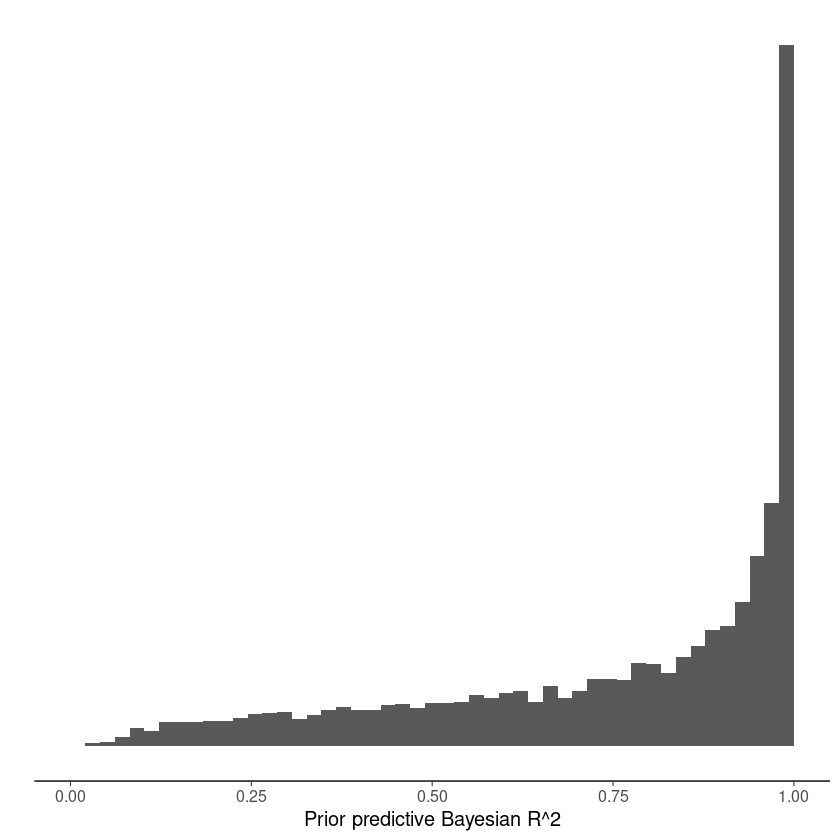

In [14]:
sims <- 10000
p <- 26
n <- 400
X <- rmvnorm(n,mean = array(0,p),sigma = diag(array(1,p)))


## Prior Predictive Graphs: Normal
ppR2_gausprior<-numeric()

for (i in 1:sims) {
  sigma2 <- rexp(1,rate=1/3)^2
  beta <- rnorm(p)
  mu <- X%*%as.vector(beta)
  muvar <- var(mu)
  ppR2_gausprior[i] <- muvar/(muvar+sigma2)
}
ggplot()+geom_histogram(aes(x=ppR2_gausprior), breaks=seq(0,1,length.out=50)) +
  xlim(c(0,1)) +
  scale_y_continuous(breaks=NULL) +
  labs(x="Prior predictive Bayesian R^2",y="")

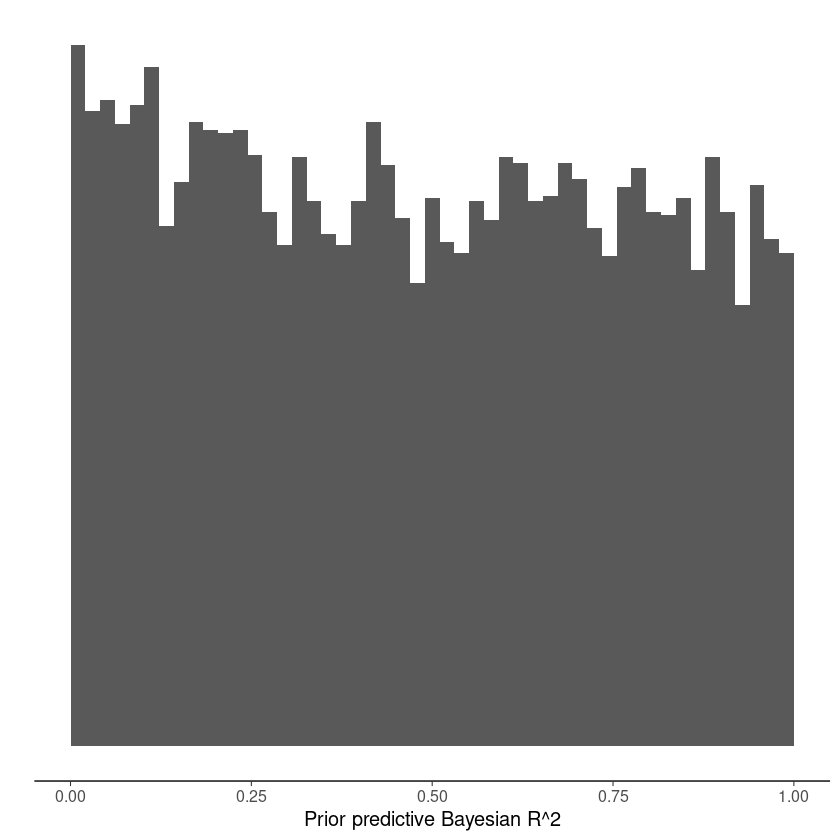

In [15]:
## Prior Predictive Graphs: R^2 prior
ppR2_r2prior<-numeric()
mu_R2 <- 0.5
scale_R2 <- 2

for (i in 1:sims) {
  sigma2 <- rexp(1,rate=1/3)^2
  R2 <- rbeta(1,(mu_R2*scale_R2),((1-mu_R2)*scale_R2))
  tau2 <- R2/(1-R2)
  psi <- rdirichlet(1,rep(1,p))
  beta <- rnorm(p) * sqrt(tau2*psi*sigma2)
  mu <- X%*%as.vector(beta)
  muvar <- var(mu)
  ppR2_r2prior[i] <- muvar/(muvar+sigma2)
}
ggplot()+geom_histogram(aes(x=ppR2_r2prior), breaks=seq(0,1,length.out=50)) +
  xlim(c(0,1)) +
  scale_y_continuous(breaks=NULL) +
  labs(x="Prior predictive Bayesian R^2",y="")

In [16]:
# Load the data
student <- read.csv(url('https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Student/data/student-merged.csv'))

# Predictors to be used
predictors <- c("school","sex","age","address","famsize","Pstatus","Medu","Fedu","traveltime","studytime","failures","schoolsup","famsup","paid","activities", "nursery", "higher", "internet", "romantic","famrel","freetime","goout","Dalc","Walc","health","absences")
p <- length(predictors)

# To reduce variability us the median grades based on those three
# exams for each topic, students with non-zero grades are selected
grades <- c("G1mat","G2mat","G3mat","G1por","G2por","G3por")
student <- student %>%
  mutate(across(matches("G[1-3]..."), ~na_if(.,0))) %>%
  mutate(Gmat = rowMedians(as.matrix(select(.,matches("G.mat"))), na.rm=TRUE),
         Gpor = rowMedians(as.matrix(select(.,matches("G.por"))), na.rm=TRUE))
student_Gmat <- subset(student, is.finite(Gmat), select=c("Gmat",predictors))
student_Gmat <- student_Gmat[is.finite(rowMeans(student_Gmat)),]
student_Gpor <- subset(student, is.finite(Gpor), select=c("Gpor",predictors))
(nmat <- nrow(student_Gmat))

[1] 382

In [17]:
# Look at the data
head(student_Gmat) |> tt()


+------+--------+-----+-----+---------+---------+---------+------+------+------------+-----------+----------+-----------+--------+------+------------+---------+--------+----------+----------+--------+----------+-------+------+------+--------+----------+
| Gmat | school | sex | age | address | famsize | Pstatus | Medu | Fedu | traveltime | studytime | failures | schoolsup | famsup | paid | activities | nursery | higher | internet | romantic | famrel | freetime | goout | Dalc | Walc | health | absences |
+======+========+=====+=====+=========+=========+=========+======+======+============+===========+==========+===========+========+======+============+=========+========+==========+==========+========+==========+=======+======+======+========+==========+
| 10   | 0      | 0   | 15  | 0       | 0       | 1       | 1    | 1    | 2          | 4         | 1        | 1         | 1      | 1    | 1          | 1       | 1      | 1        | 0        | 3      | 1        | 2     | 1    | 1    | 1  

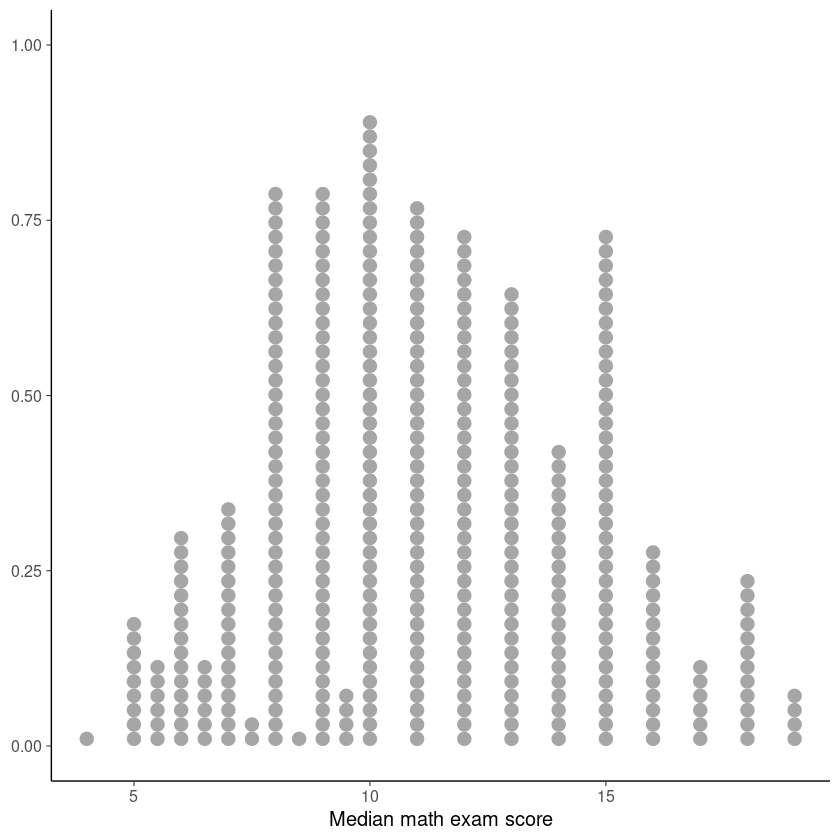

In [18]:
# Visualise the distributions of median math scores
p1 <- ggplot(student_Gmat, aes(x=Gmat)) + geom_dots() + labs(x='Median math exam score')
p1

In [19]:
# Some data transformation for non-binary predictors to have standard
# deviation 1
studentstd_Gmat <- student_Gmat
Gmatbin<-apply(student_Gmat[,predictors], 2, function(x) {length(unique(x))==2})
studentstd_Gmat[,predictors[!Gmatbin]] <-scale(student_Gmat[,predictors[!Gmatbin]])
studentstd_Gpor <- student_Gpor
Gporbin<-apply(student_Gpor[,predictors], 2, function(x) {length(unique(x))==2})
studentstd_Gpor[,predictors[!Gporbin]] <-scale(student_Gpor[,predictors[!Gporbin]])

# Set Seed for reproducibility
SEED <- 2132

3.2 Normal model

In [22]:
# Estimate Model
fit1 <- brm(Gmat ~ ., data = studentstd_Gmat,
             normalize=FALSE,
            seed = SEED)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.255 seconds (Warm-up)
Chain 1:                0.205 seconds (Sampling)
Chain 1:                0.46

In [23]:
# Plot marginal posteriors of the coefficients
drawsmu <- as_draws_df(fit1, variable=paste0('b_',predictors)) |>
  set_variables(predictors)

In [24]:
p <- mcmc_areas(drawsmu,
                prob_outer=0.98, area_method = "scaled height") +
  xlim(c(-3,3))

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


In [25]:
p <- p + scale_y_discrete(limits = rev(levels(p$data$parameter)))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


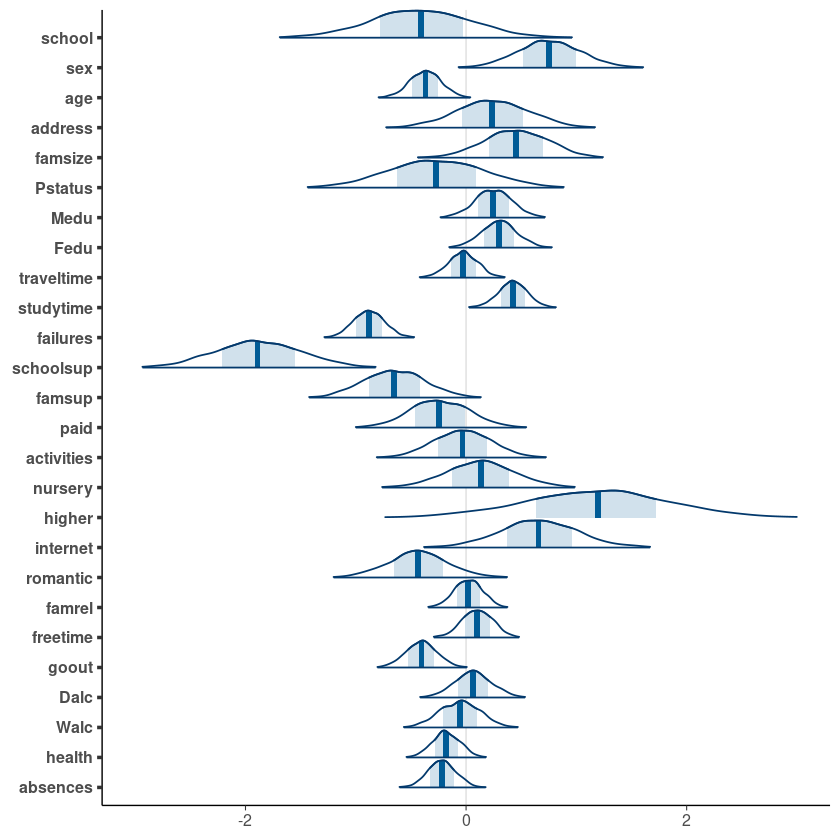

In [26]:
p

Now find the prior predictive R2

In [27]:
X <- studentstd_Gmat[,2:dim(student_Gmat)[2]] 

ppR2_1<-numeric()
sims <- 4000

for (i in 1:sims) {
  sigma2 <- rstudent_t(1,3,0,3)^2
  beta <- rnorm(length(predictors))
  mu <- as.matrix(X)%*%as.vector(beta)
  muvar <- var(mu)
  ppR2_1[i] <- muvar/(muvar+sigma2)
}

In [28]:
data <- data.frame(Prior=ppR2_1,Posterior=bayes_R2(fit1, summary=FALSE)) 

In [29]:
names(data) <- c("Prior","Posterior")

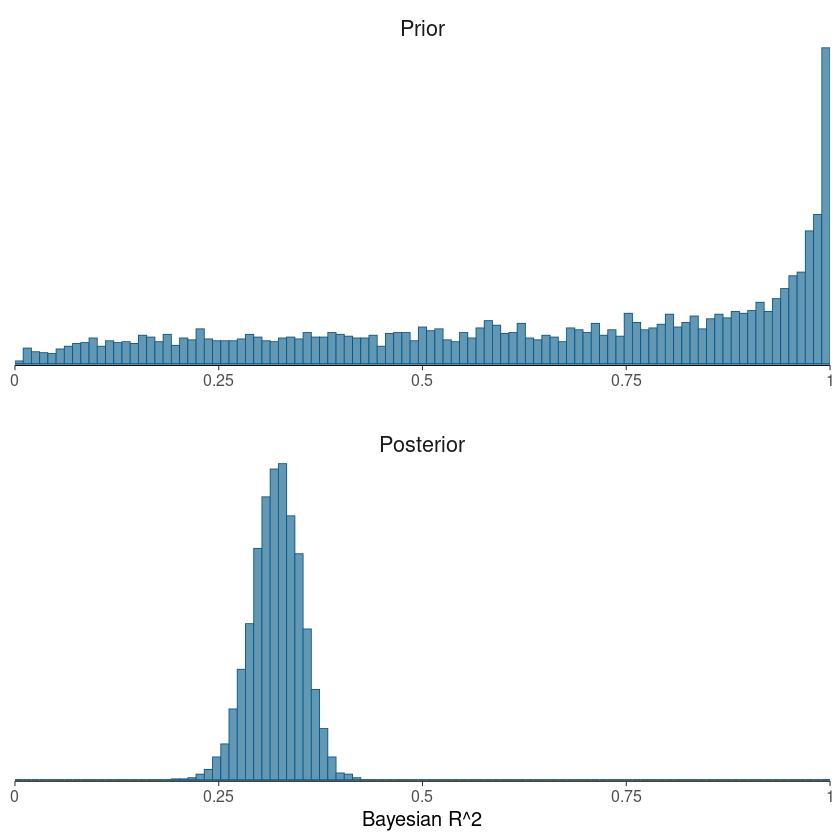

In [30]:
mcmc_hist(data,
          breaks=seq(0,1,length.out=100),
          facet_args = list(nrow = 2)) +
  facet_text(size = 13) +
  scale_x_continuous(limits = c(0,1), expand = c(0, 0),
                     labels = c("0","0.25","0.5","0.75","1")) +
  theme(axis.line.y = element_blank()) +
  xlab("Bayesian R^2")

In [31]:
bayes_R2(fit1) |> as.data.frame() |> tt()


+-----------+------------+-----------+-----------+
| Estimate  | Est.Error  | Q2.5      | Q97.5     |
+===========+============+===========+===========+
| 0.3207755 | 0.03052689 | 0.2584229 | 0.3780315 |
+-----------+------------+-----------+-----------+ 

In [32]:
loo_R2(fit1) |> as.data.frame() |> tt()


+-----------+------------+-----------+-----------+
| Estimate  | Est.Error  | Q2.5      | Q97.5     |
+===========+============+===========+===========+
| 0.1953217 | 0.03999343 | 0.1156101 | 0.2719846 |
+-----------+------------+-----------+-----------+ 

now Now use the R2
 prior with μR2=1/3,σR2=3
 

In [38]:
library(cmdstanr)
fit2 <- brm(Gmat ~ ., data = studentstd_Gmat,
            seed = SEED,
            normalize = FALSE,
            prior=c(prior(R2D2(mean_R2 = 0.5, prec_R2 = 1, cons_D2 = 1,
                               autoscale = TRUE),class=b)),
            backend = "cmdstanr")

error: error opening 'src/cmdstan/main_threads.d': Read-only file system
1 error generated.


error: unable to open output file 'stan/src/stan/model/model_header.hpp.gch/model_header_threads_14_0.hpp.gch': 'Read-only file system'
1 error generated.


Warning message:
“CmdStan's precompiled header (PCH) files may need to be rebuilt.
If your model failed to compile please run rebuild_cmdstan().
If the issue persists please open a bug report.”
make: *** [make/program:28: stan/src/stan/model/model_header.hpp.gch/model_header_threads_14_0.hpp.gch] Error 1


Warning message:
“CmdStan's precompiled header (PCH) files may need to be rebuilt.
If your model failed to compile please run rebuild_cmdstan().
If the issue persists please open a bug report.”


ERROR: Error: An error occured during compilation! See the message above for more information.


In [ ]:
# Plot marginal posteriors
draws2 <- as_draws_df(fit2, variable=paste0('b_',predictors)) |>
  set_variables(predictors)
p <- mcmc_areas(draws2,
                prob_outer=0.98, area_method = "scaled height") +
  xlim(c(-3,3))

In [ ]:
p <- p + scale_y_discrete(limits = rev(levels(p$data$parameter)))

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


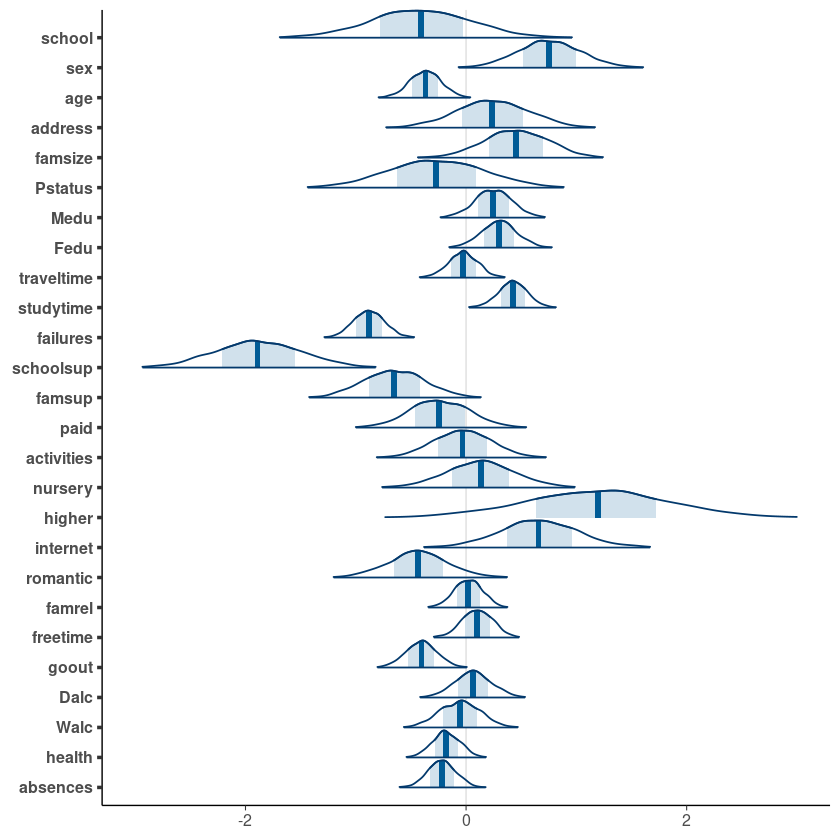

In [34]:
p

In [35]:
ppR2_2<-numeric()
sims <- 4000

for (i in 1:sims) {
  sigma2 <- rstudent_t(1,3,0,3)^2
  R2 <- rbeta(1,1,2)
  tau2 <- R2/(1-R2)
  psi <- as.numeric(rdirichlet(1,rep(1,dim(X)[2])))
  beta <- rnorm(dim(X)[2])*sqrt(sigma2*tau2*psi)
  mu <- as.matrix(X)%*%as.vector(beta)
  muvar <- var(mu)
  ppR2_2[i] <- muvar/(muvar+sigma2)
}

In [36]:
# Prior vs posterior R2
data <- data.frame(Prior=ppR2_2,Posterior=bayes_R2(fit2, summary=FALSE)) 
names(data) <- c("Prior","Posterior")
mcmc_hist(data,
          breaks=seq(0,1,length.out=100),
          facet_args = list(nrow = 2)) +
  facet_text(size = 13) +
  scale_x_continuous(limits = c(0,1), expand = c(0, 0),
                     labels = c("0","0.25","0.5","0.75","1")) +
  theme(axis.line.y = element_blank()) +
  xlab("Bayesian R^2")

ERROR: Error: object 'fit2' not found


In [37]:
# Prior vs posterior R2
data <- data.frame(Prior=ppR2_2,Posterior=bayes_R2(fit2, summary=FALSE)) 
names(data) <- c("Prior","Posterior")
mcmc_hist(data,
          breaks=seq(0,1,length.out=100),
          facet_args = list(nrow = 2)) +
  facet_text(size = 13) +
  scale_x_continuous(limits = c(0,1), expand = c(0, 0),
                     labels = c("0","0.25","0.5","0.75","1")) +
  theme(axis.line.y = element_blank()) +
  xlab("Bayesian R^2")

ERROR: Error: object 'fit2' not found


In [20]:
library(brms)
fit <- brm(
  Gmat ~ ., 
  data = student_Gmat, 
  family = gaussian(), 
  prior = prior(normal(0, 1), class = "b"),
  seed = 123
)


Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000163 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.63 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.335 seconds (Warm-up)
Chain 1:                0.243 seconds (Sampling)
Chain 1:                0.5

Warning message:
“Method 'marginal_effects' is deprecated. Please use 'conditional_effects' instead.”


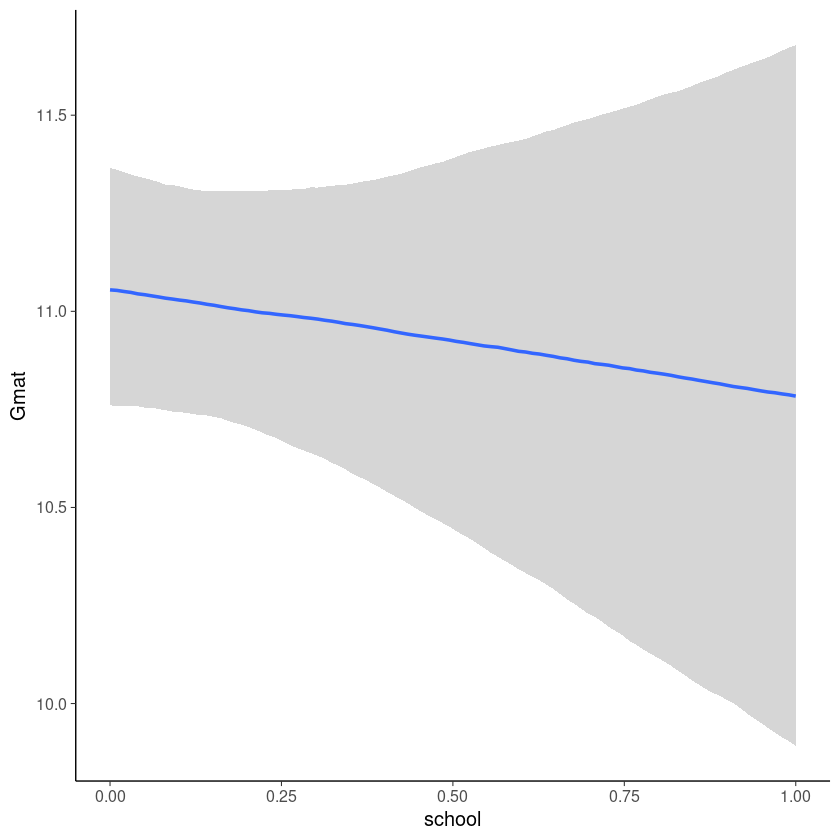

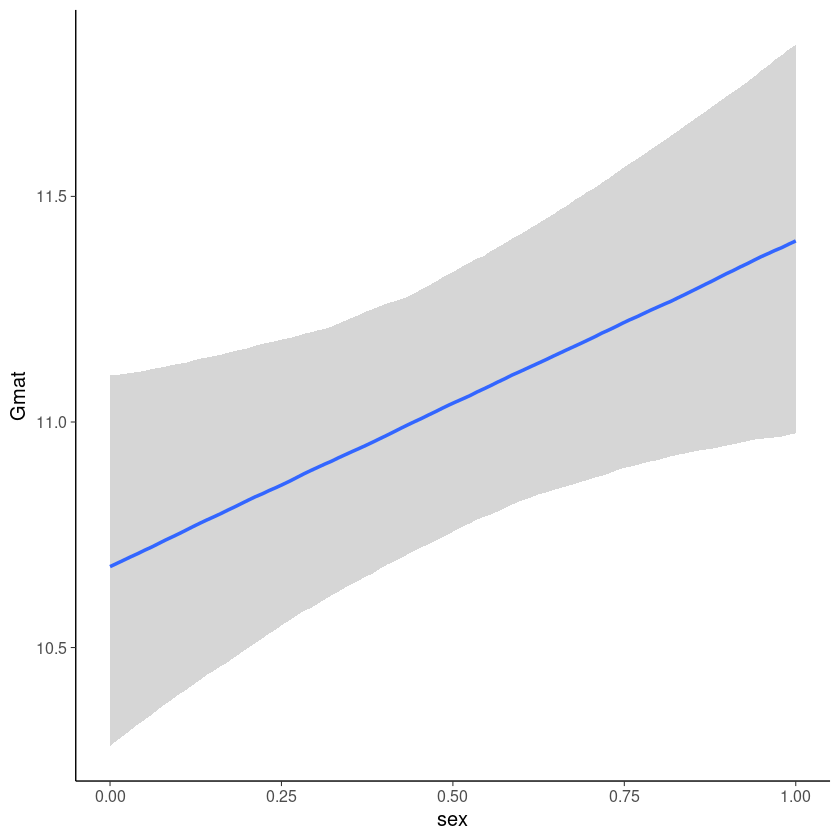

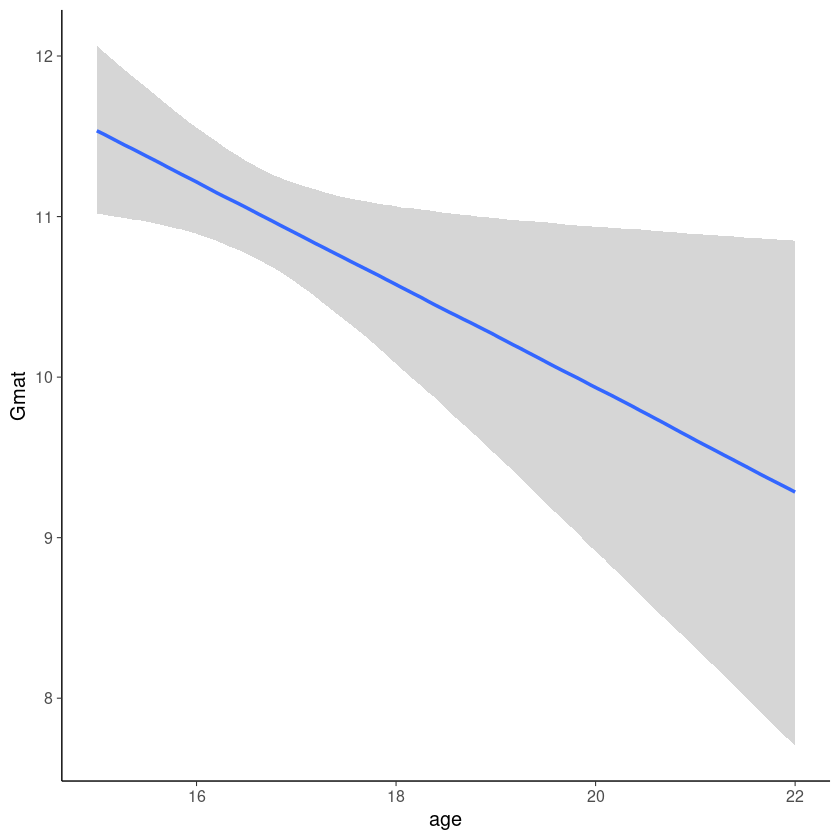

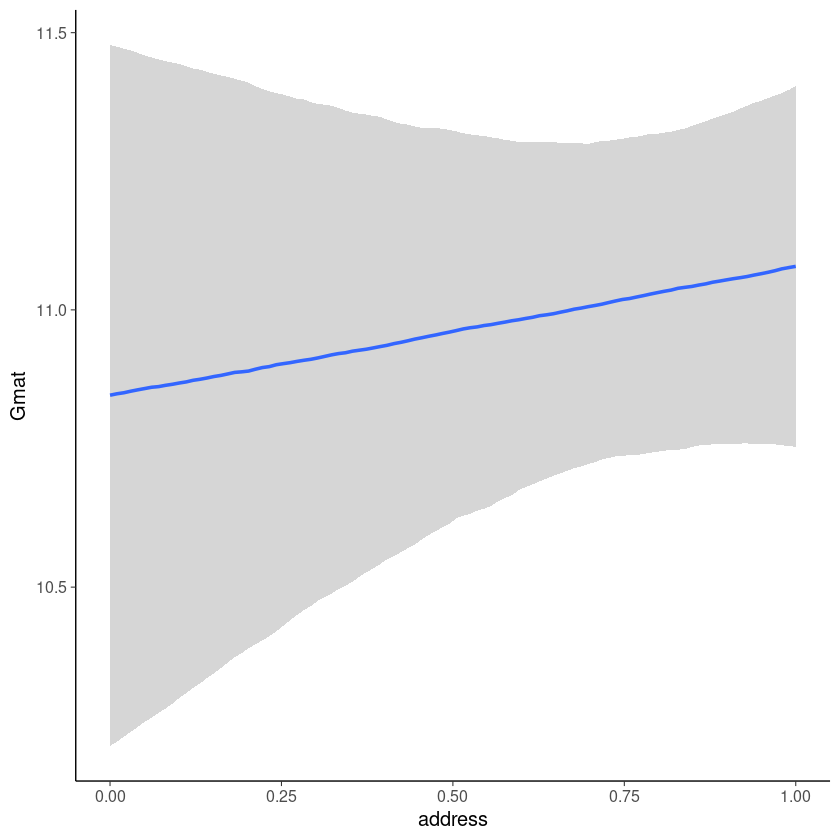

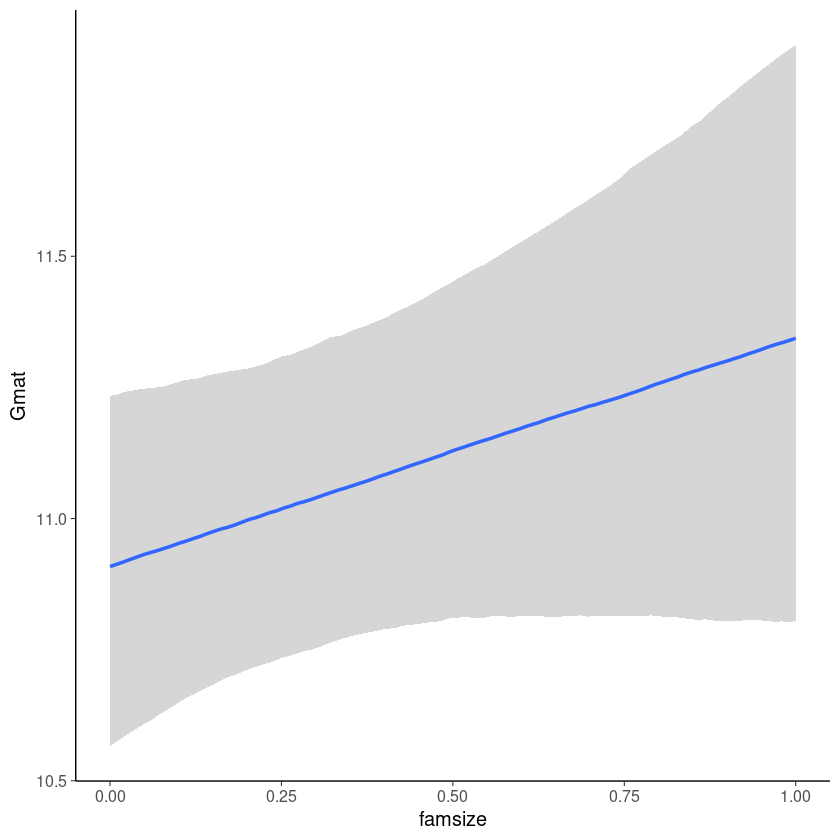

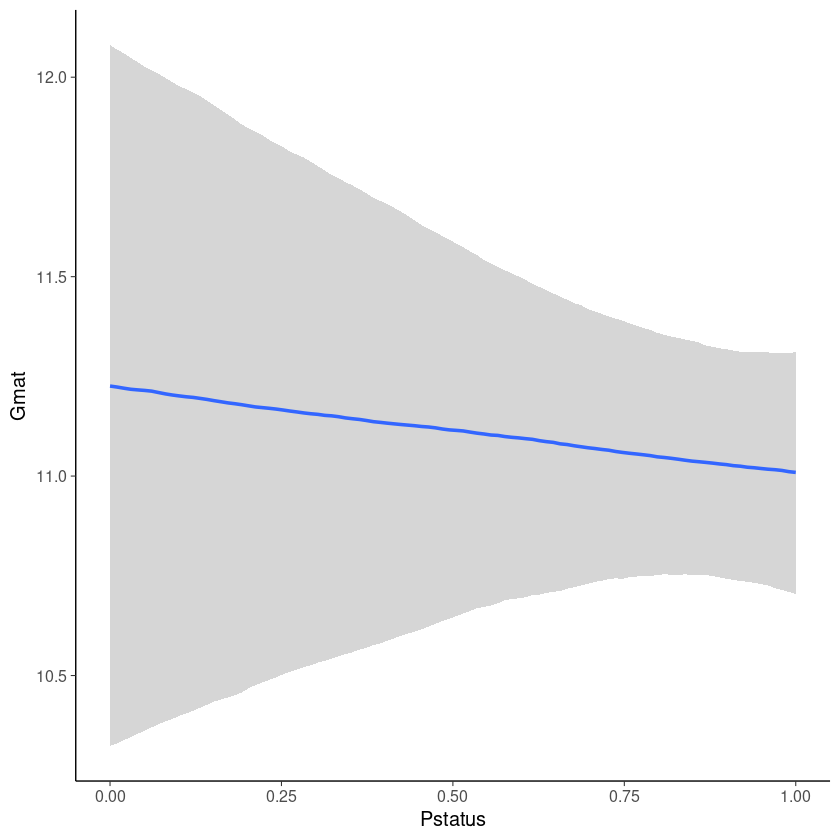

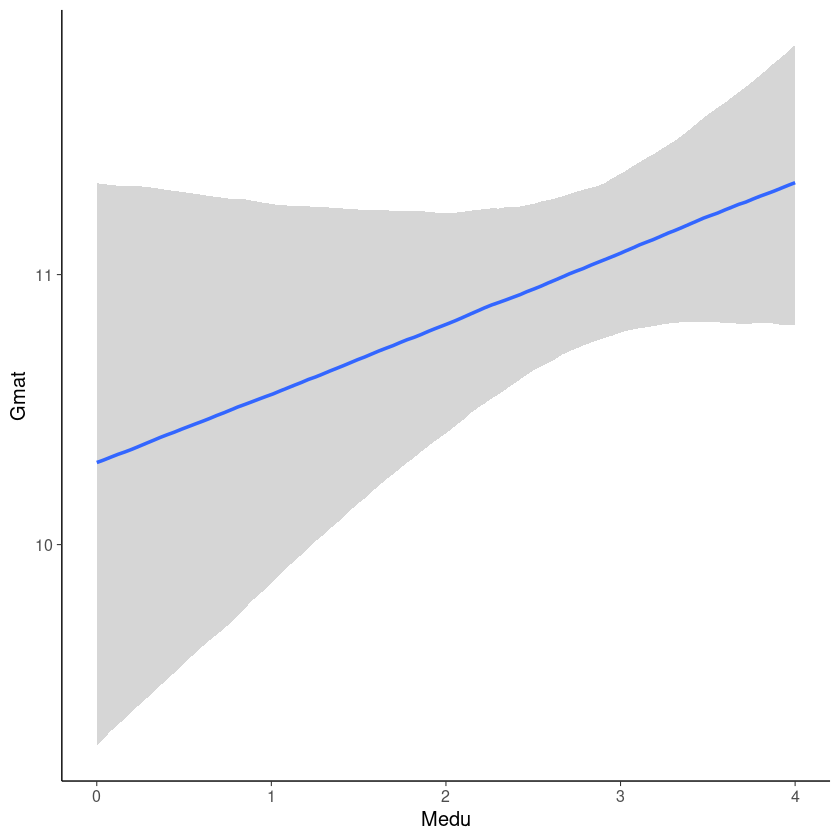

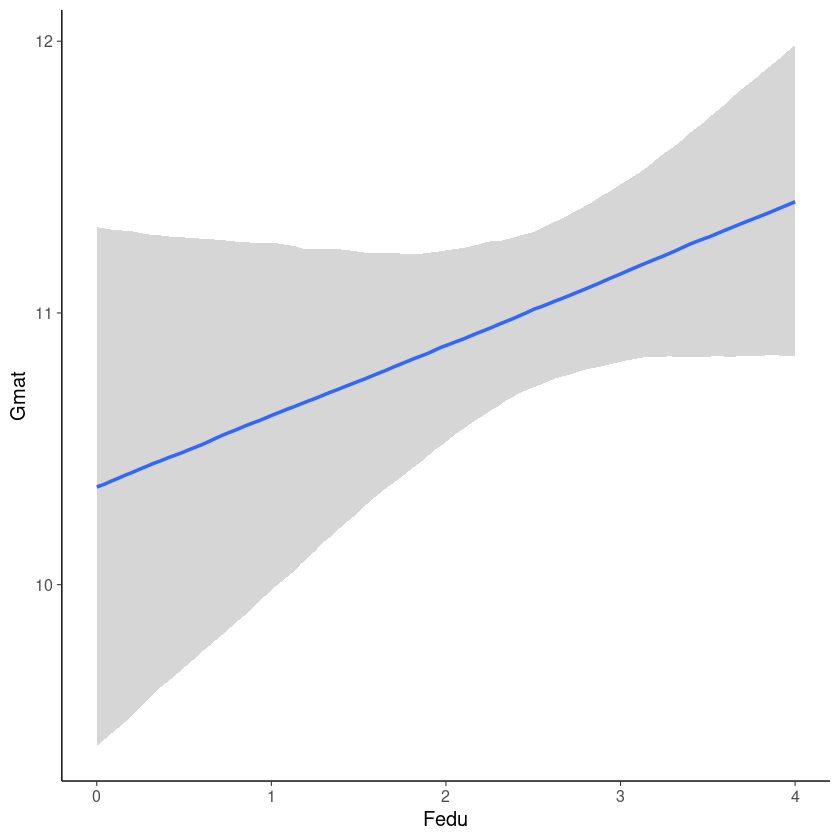

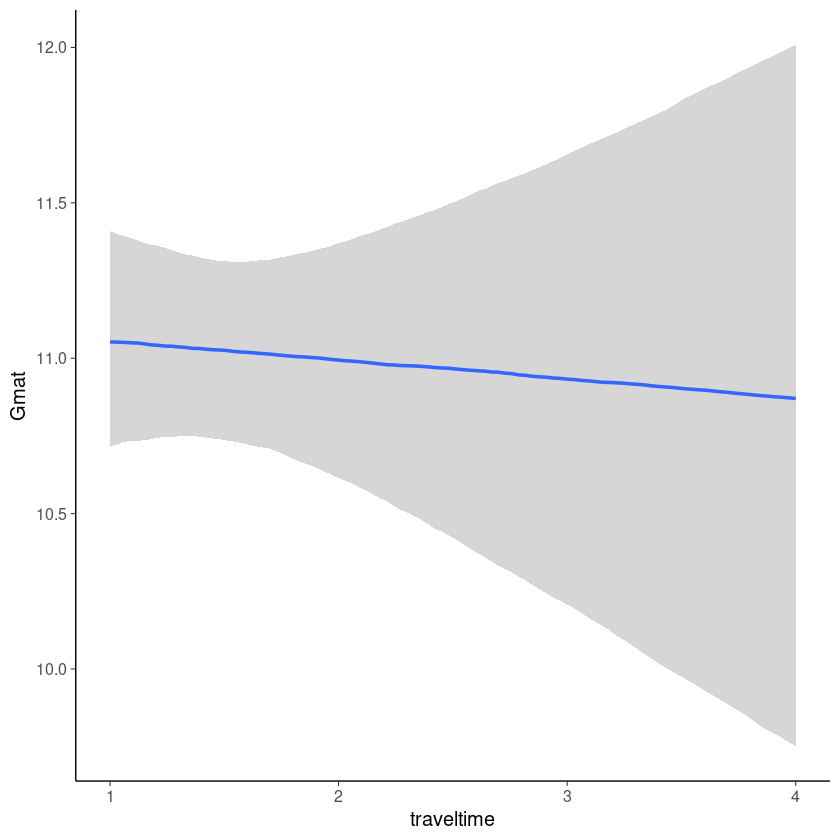

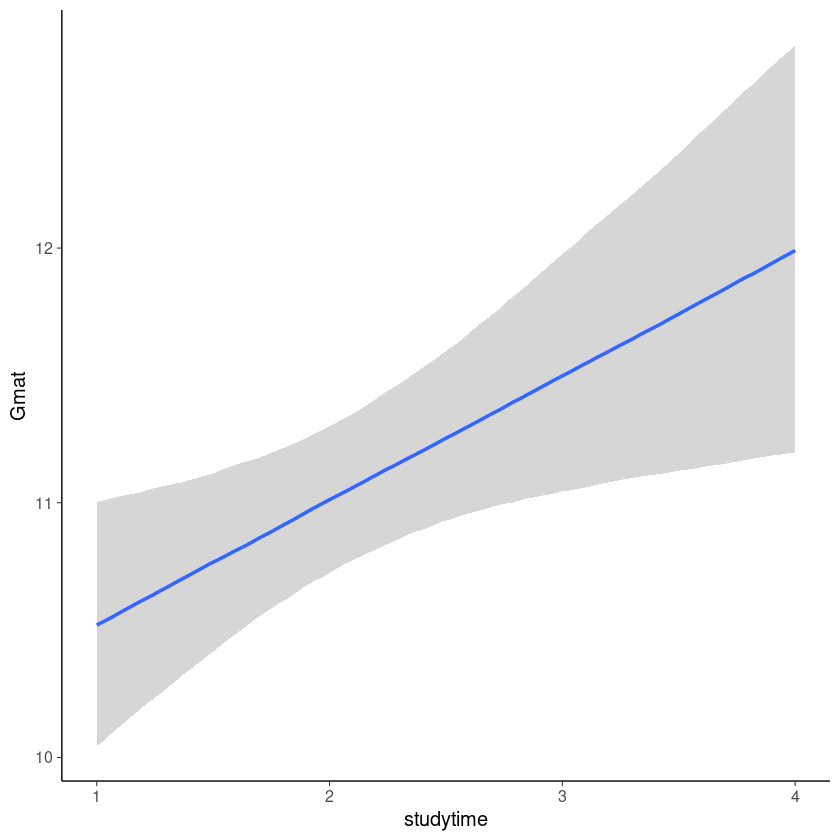

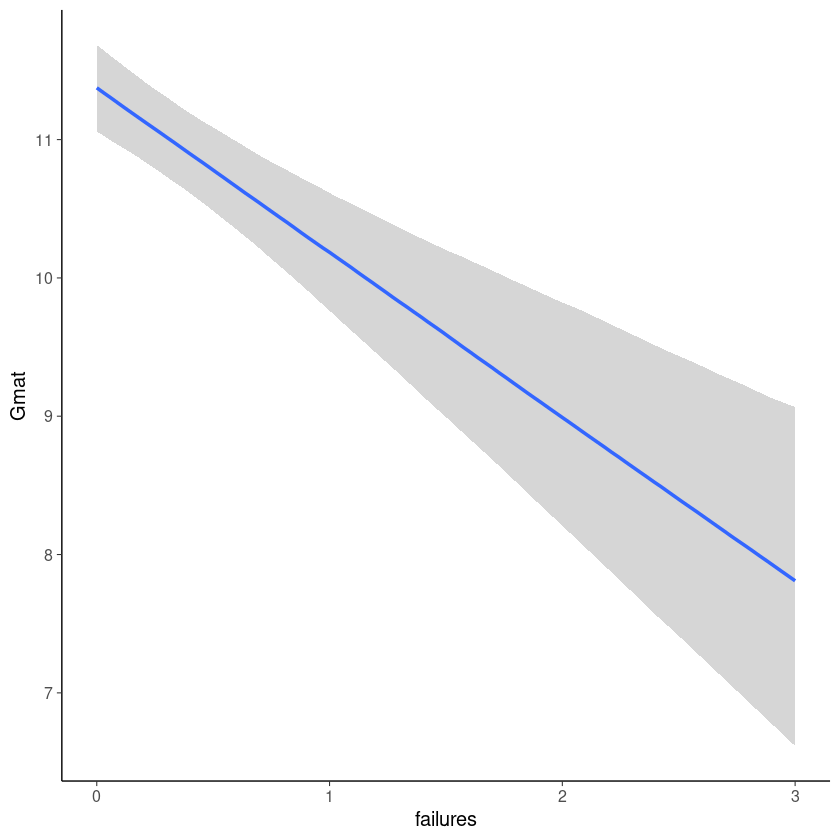

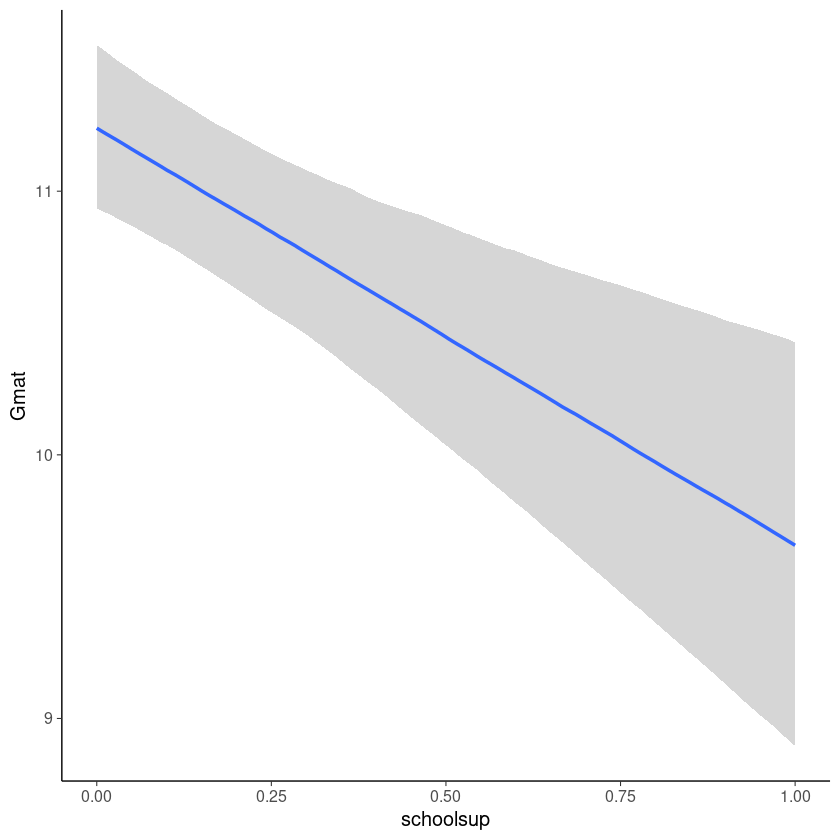

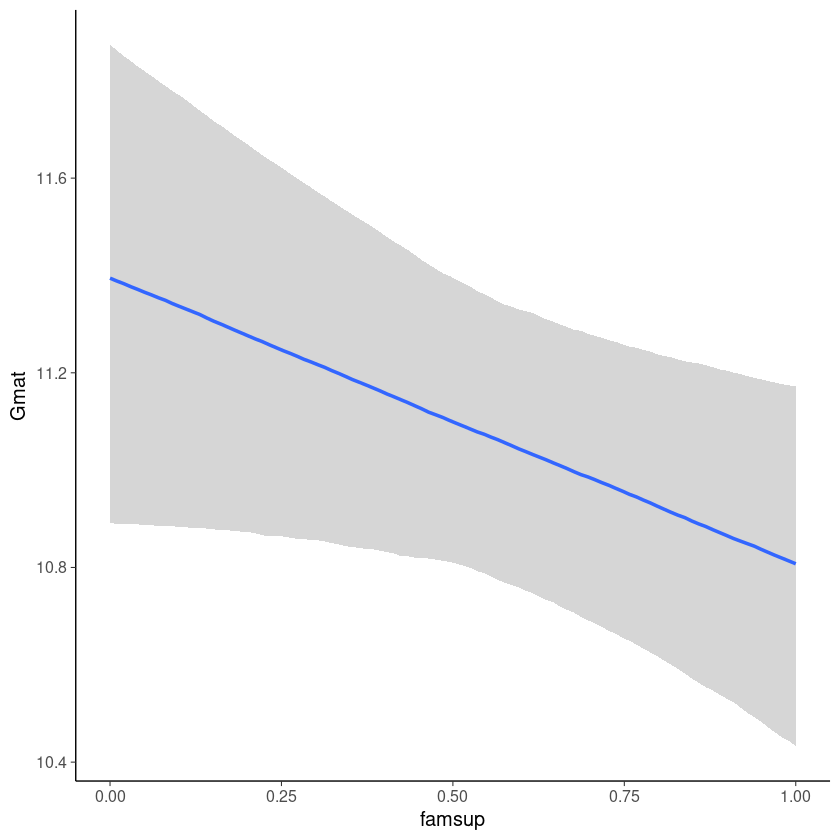

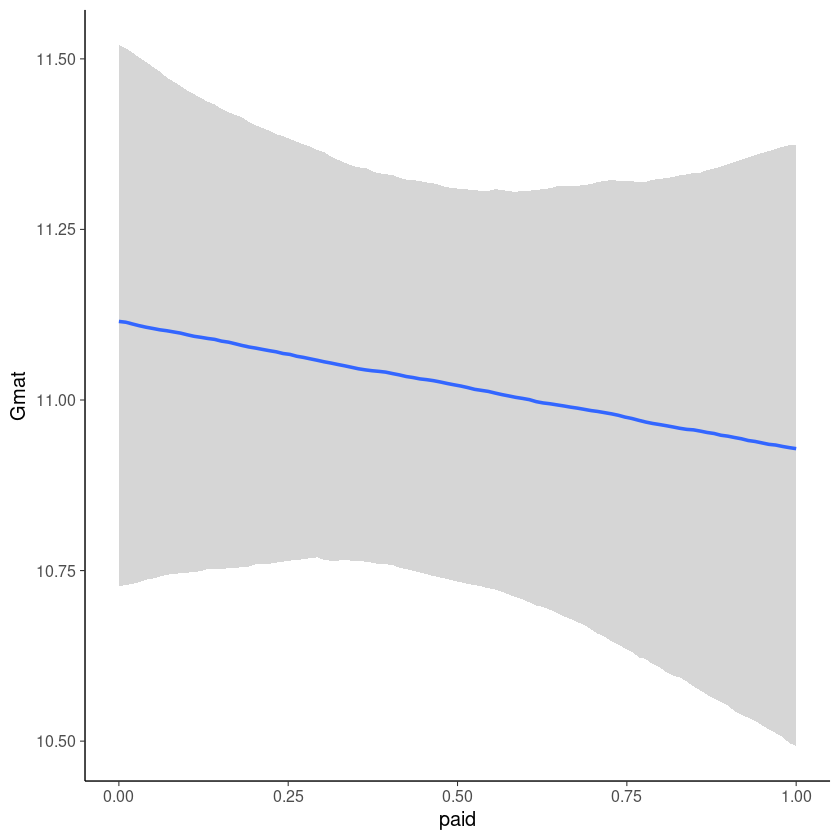

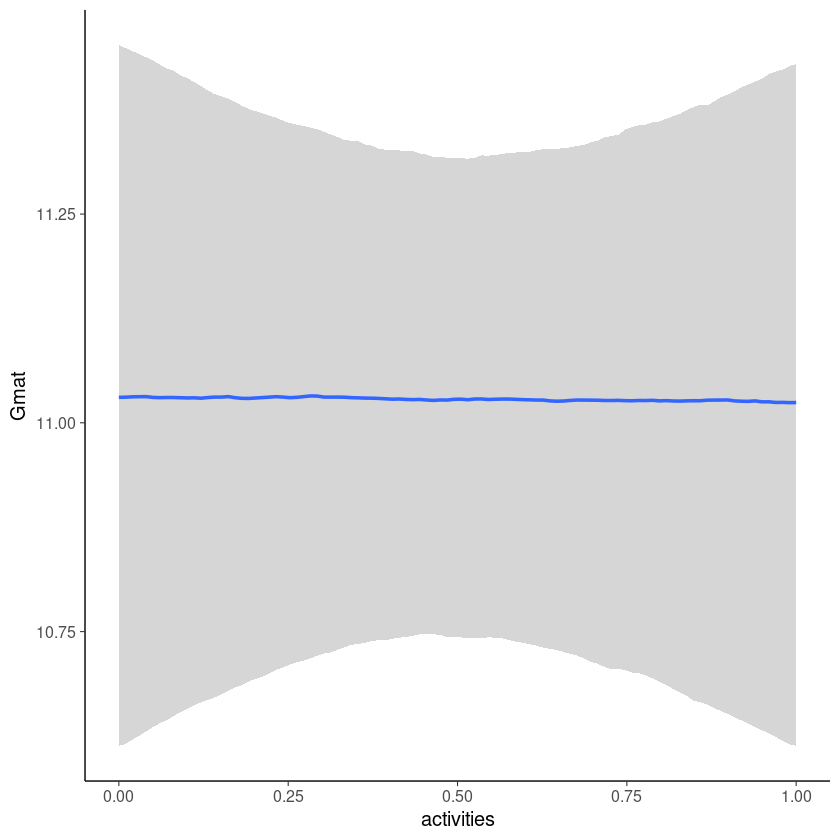

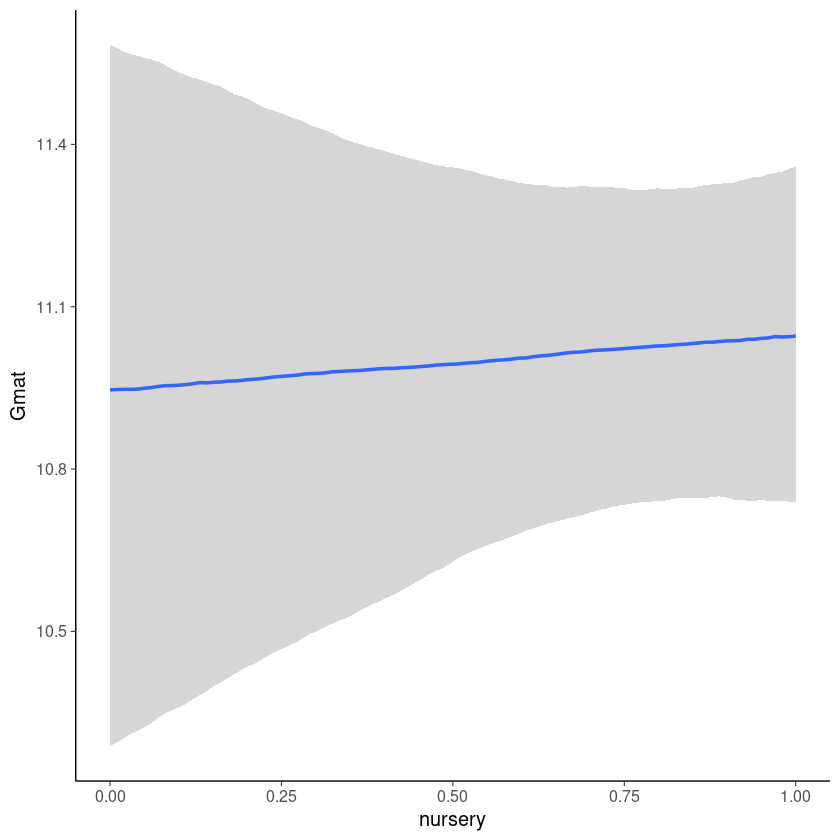

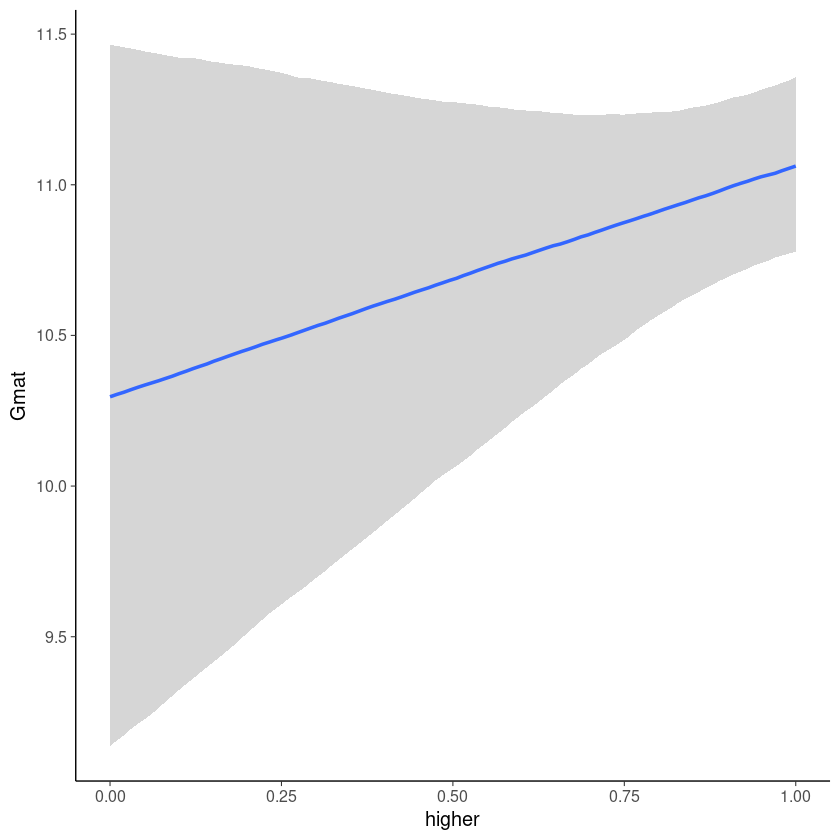

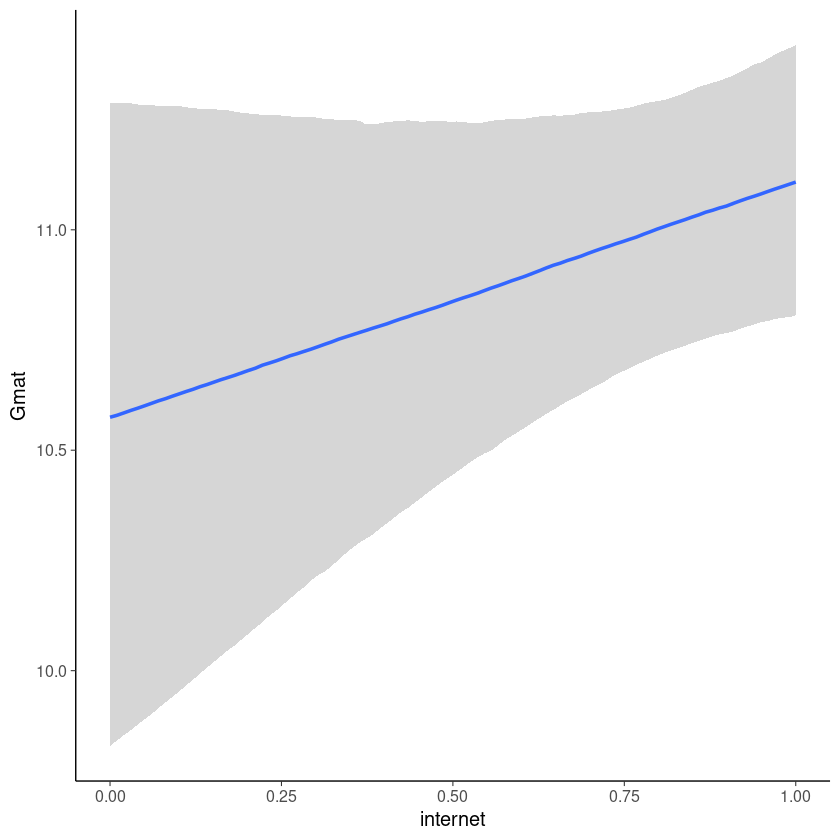

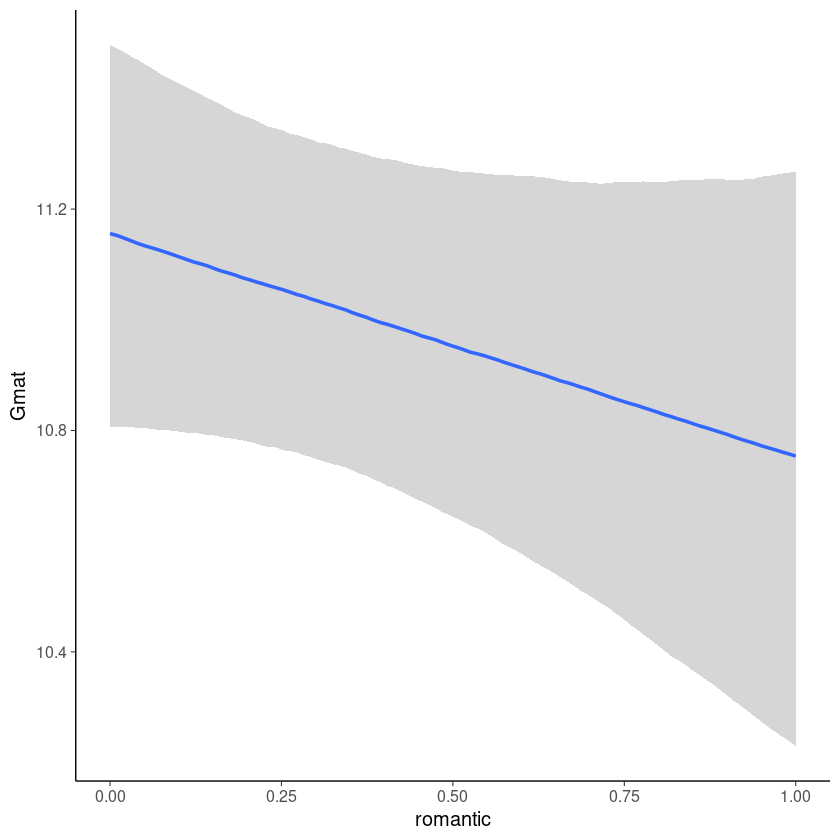

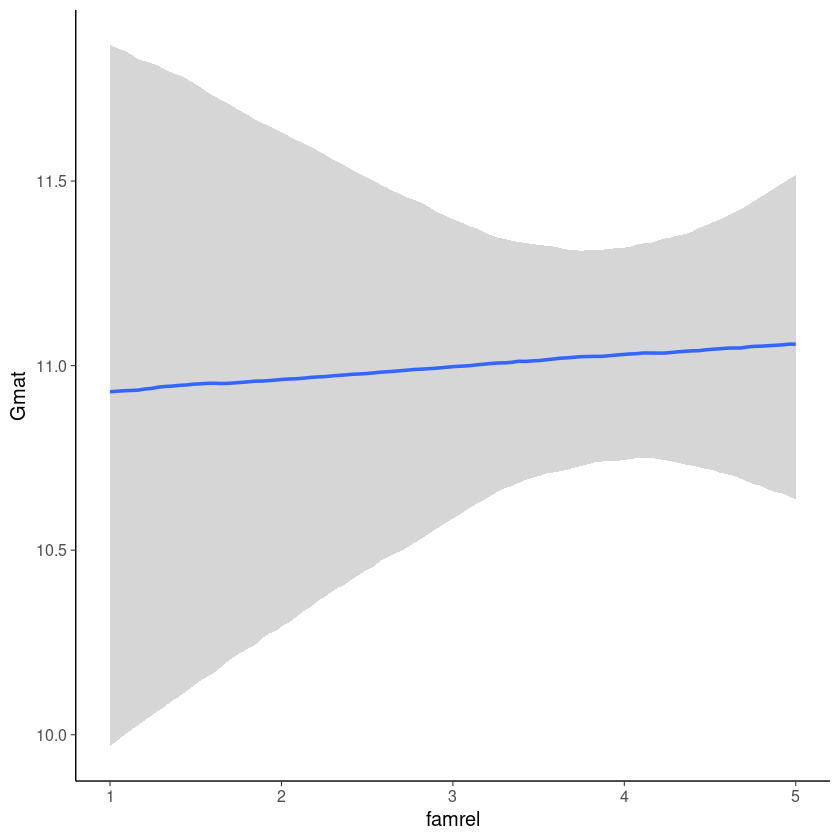

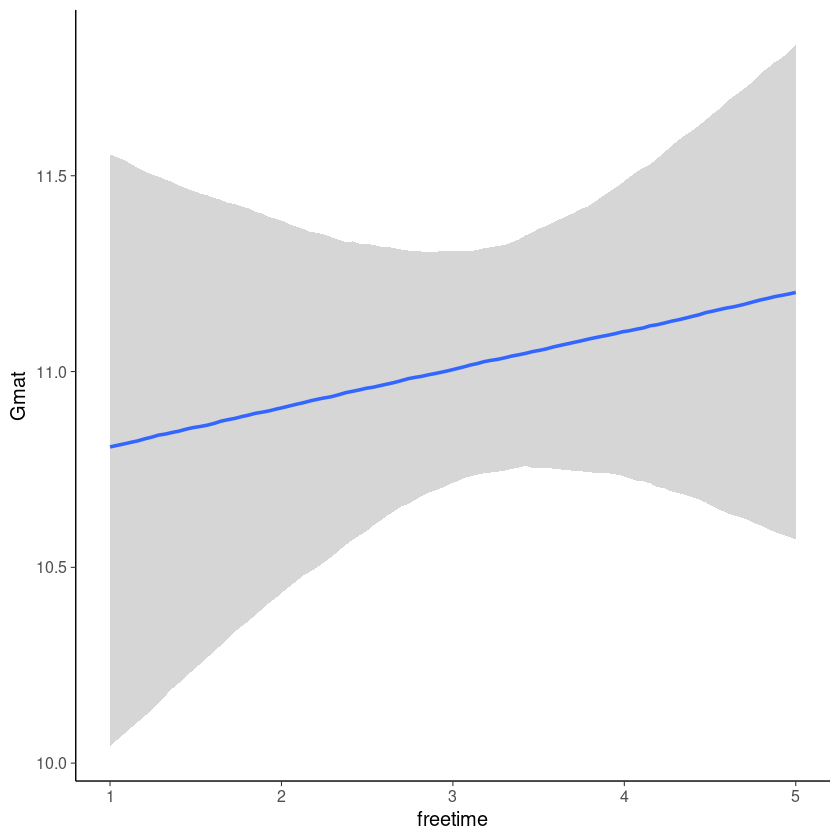

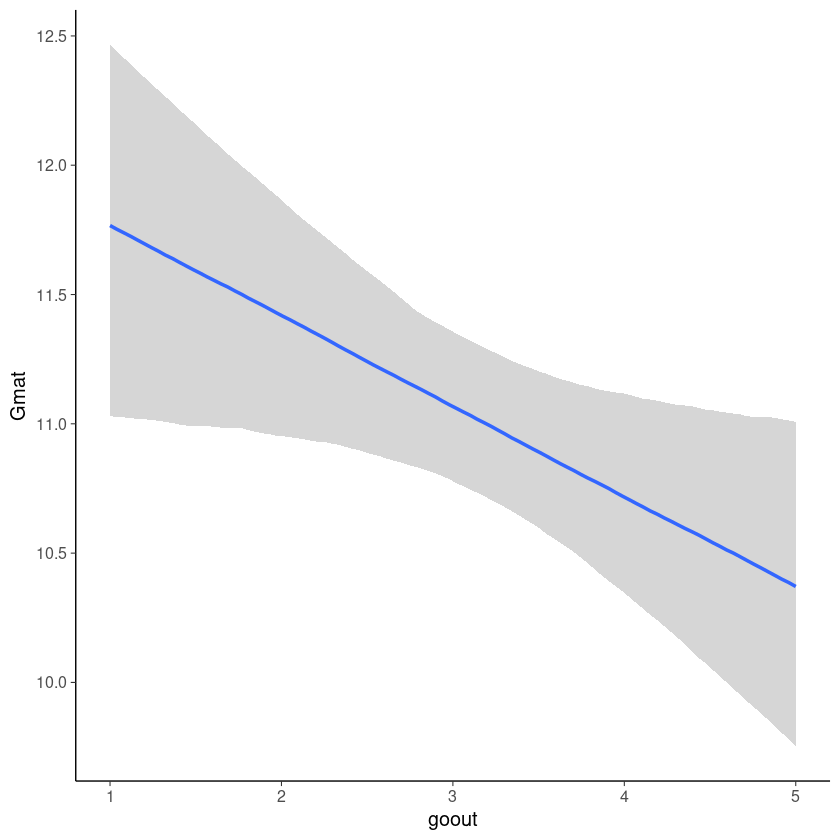

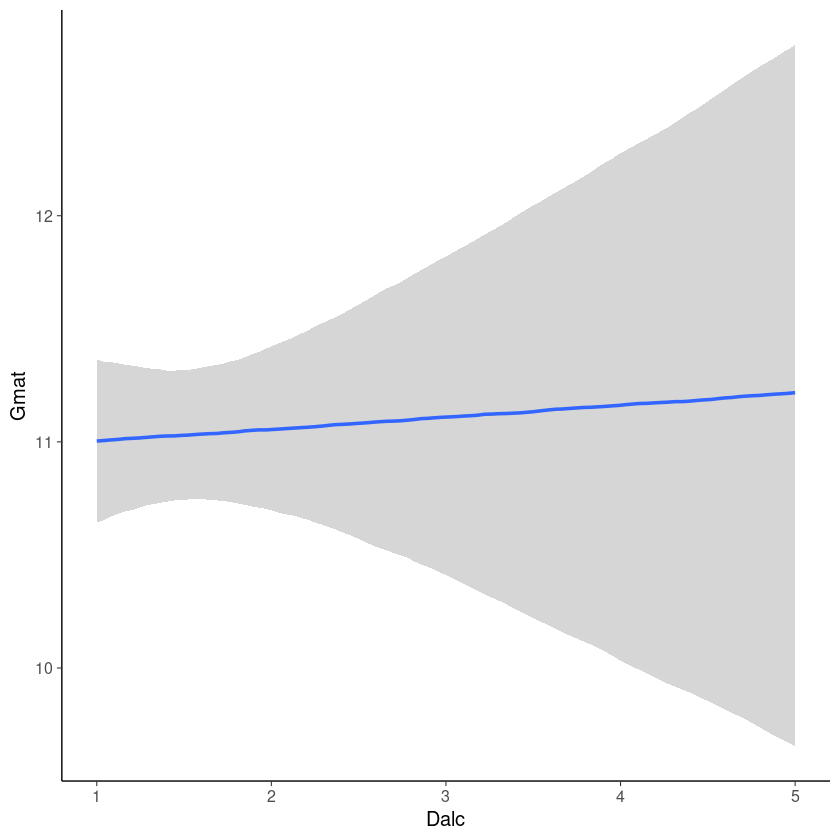

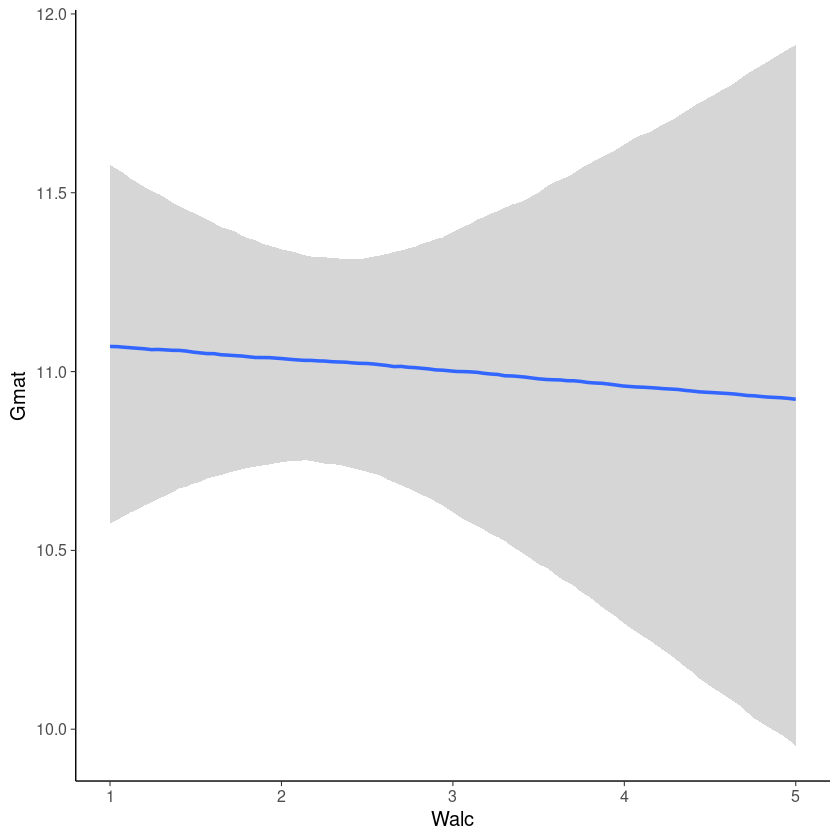

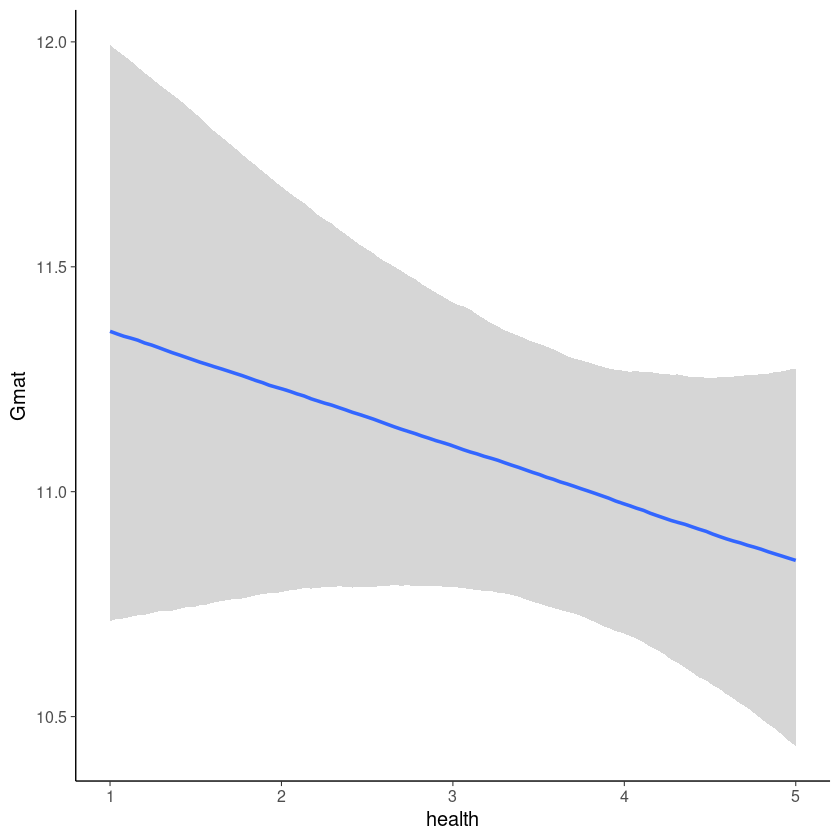

ERROR: [1m[33mError[39m in `select_parameters()`:[22m
[33m![39m Some 'pars' don't match parameter names: b_* FALSE


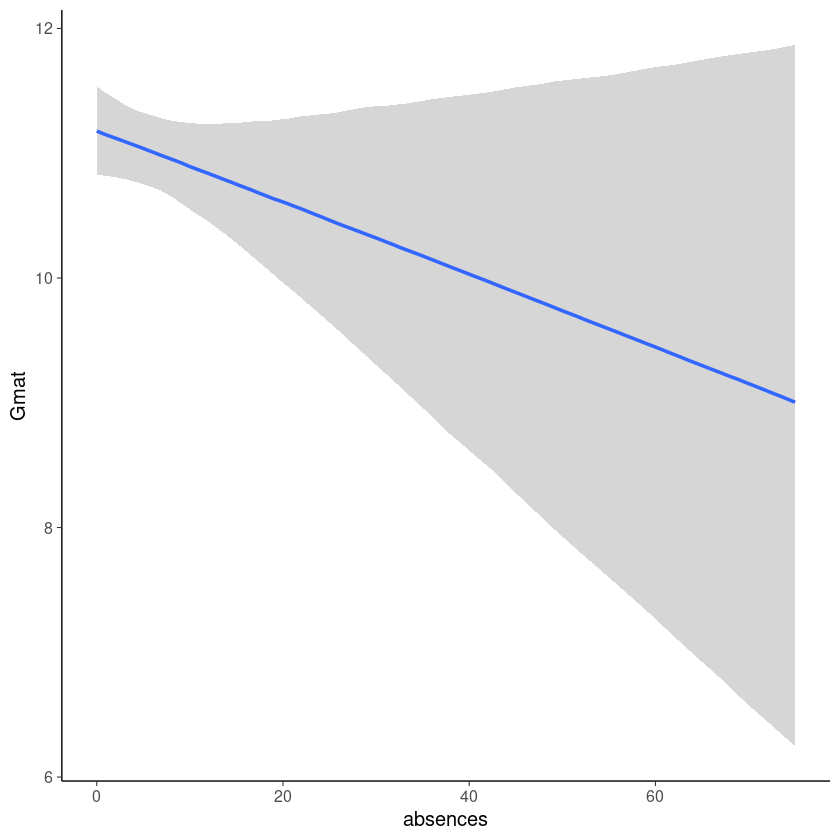

In [21]:
plot(marginal_effects(fit))
mcmc_areas(as_draws_df(fit), pars = "b_*")


In [ ]:
# Load brms package (assuming it's not already loaded)
library(brms)

prior1 <- c(
  prior(normal(0, 0.5), class = "b"),  # Weakly informative prior for coefficients
  prior(inv_chi_square(df = 3, scale = 0.5), class = "sigma")  # Prior for residual standard deviation
)

# Include the R2D2 prior in the model formula
fit_r2d2 <- brm(Gmat ~ ., 
                 data = student_Gmat, 
                 family = gaussian(), 
                 prior = prior1, 
                 seed = 123)

# Extract posterior samples for R-squared
post_R2 <- summary(fit_r2d2)$rsquared

# Calculate prior R-squared (analytical formula for R2D2 doesn't exist)
# We can approximate it by simulating from the prior
prior_draws <- rstanarm::sample(fit_r2d2, pars = c("b"), n_draws = 10000)
prior_R2 <- lm(Gmat ~ ., data = student_Gmat)$rsquared[1] * 
            mean(apply(coef(lm(Gmat ~ ., data = student_Gmat)), 1, var)) / 
            var(prior_draws$b)

# Plot the prior and posterior R-squared distributions
library(ggplot2)
ggplot(data = rbind(data.frame(R2 = prior_R2, label = "Prior"), 
                     data.frame(R2 = post_R2, label = "Posterior")), 
       aes(x = R2, y = density(R2))) + 
  geom_density(aes(color = label), alpha = 0.5) + 
  labs(title = "Prior and Posterior R-squared Distributions", 
       x = "R-squared", y = "Density") + 
  theme_bw()

# Print some summary statistics for R-squared
print(summary(post_R2))

In [ ]:
# Simulate from the prior
prior_samples <- rstanarm::posterior_predict(fit_r2d2, draws = 10000, nsamples = 1)

# Calculate R-squared for each sample
prior_R2_samples <- apply(prior_samples, 2, function(x) {
  lm_fit <- lm(x ~ student_Gmat[, -1])
  summary(lm_fit)$r.squared
})

# Calculate the mean prior R-squared
mean_prior_R2 <- mean(prior_R2_samples)

# Plot the prior and posterior R-squared distributions
ggplot(data = rbind(data.frame(R2 = mean_prior_R2, label = "Prior"), 
                     data.frame(R2 = post_R2, label = "Posterior")), 
       aes(x = R2, y = density(R2))) + 
  geom_density(aes(color = label), alpha = 0.5) + 
  labs(title = "Prior and Posterior R-squared Distributions", 
       x = "R-squared", y = "Density") + 
  theme_bw()